In [2]:
!pip install gymnasium

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)


In [10]:
import numpy as np
from gymnasium import spaces
import gymnasium as gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from environment import SnakeGame

In [14]:
class QModel(tf.keras.Model):
    def __init__(self, grid_size, num_actions):
        super(QModel, self).__init__()
        self.grid_size = grid_size
        self.num_actions = num_actions
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.output_layer = Dense(num_actions, activation='linear')

    def call(self, inputs):
        grid, direction = inputs
        grid_flat = self.flatten(grid)
        direction = tf.cast(direction, tf.float32)  # Ensure direction is float for concatenation
        concat = Concatenate()([grid_flat, direction])
        x = self.dense1(concat)
        x = self.dense2(x)
        output = self.output_layer(x)
        return output

def create_q_model(grid_size, num_actions):
    grid_input = Input(shape=(grid_size, grid_size, 1), name='grid')
    direction_input = Input(shape=(1,), name='direction')

    model = QModel(grid_size, num_actions)
    outputs = model([grid_input, direction_input])

    q_model = Model(inputs=[grid_input, direction_input], outputs=outputs)
    q_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse')
    return q_model

In [11]:
env = SnakeGame()
env.observation_space

Dict('direction': Box(0, 3, (1,), int32), 'grid': Box(0, 3, (8, 8), uint8))

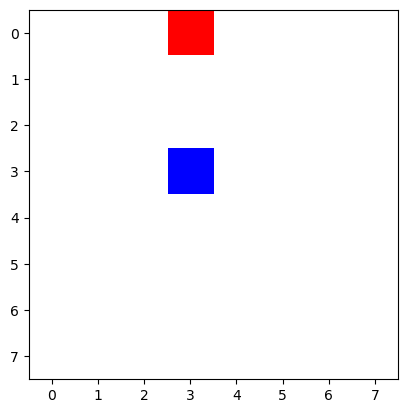

In [12]:
def renderImg(env: gym.Env):
  img = env.render()
  plt.imshow(img)
  plt.show()

renderImg(env)

In [13]:
import collections
import random

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = collections.deque(maxlen=size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [15]:
# Parameters
num_actions = 3  # Number of actions (STRAIGHT, TURN_LEFT, TURN_RIGHT)
grid_size = 8  # Assuming an 8x8 grid
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration
batch_size = 64  # Batch size for training
train_start = 1000  # Number of experiences to collect before training
num_episodes = 1000  # Number of episodes to train

# Initialize models
model = create_q_model(grid_size, num_actions)
target_model = create_q_model(grid_size, num_actions)
target_model.set_weights(model.get_weights())

# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.Huber()

# Replay buffer
replay_buffer = ReplayBuffer(2000)

# Training loop
for episode in range(num_episodes):
    state, _ = env.reset()
    grid = np.expand_dims(state['grid'], axis=-1)  # Expand dimensions to match (grid_size, grid_size, 1)
    direction = np.array([state['direction']], dtype=np.float32)
    total_reward = 0
    done = False

    while not done:
        # Select action
        if np.random.rand() <= epsilon:
            action = np.random.choice(num_actions)
        else:
            q_values = model.predict([np.expand_dims(grid, axis=0), np.expand_dims(direction, axis=0)])
            action = np.argmax(q_values[0])

        # Take action
        next_state, reward, done, _ = env.step(action)
        next_grid = np.expand_dims(next_state['grid'], axis=-1)
        next_direction = np.array([next_state['direction']], dtype=np.float32)
        total_reward += reward

        # Store experience in replay buffer
        replay_buffer.add(((grid, direction), action, reward, (next_grid, next_direction), done))
        grid, direction = next_grid, next_direction

        # Training step
        if len(replay_buffer) >= train_start:
            batch = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            grids, directions = zip(*[state for state, _, _, _, _ in batch])
            next_grids, next_directions = zip(*[next_state for _, _, _, next_state, _ in batch])

            grids = np.array(grids)
            directions = np.array(directions)
            next_grids = np.array(next_grids)
            next_directions = np.array(next_directions)

            # Ensure the shapes are consistent
            if len(grids) != len(directions) or len(next_grids) != len(next_directions):
                print("Error: Mismatch in data sizes.")
                continue

            # Compute target Q-values
            next_q_values = target_model.predict([next_grids, next_directions])
            max_next_q_values = np.amax(next_q_values, axis=1)
            target_q_values = rewards + (1 - np.array(dones)) * gamma * max_next_q_values

            # Update Q-values for actions taken
            q_values = model.predict([grids, directions])
            q_values[range(batch_size), actions] = target_q_values

            # Train model
            model.train_on_batch([grids, directions], q_values)

        # Update target model
        if episode % 10 == 0:
            target_model.set_weights(model.get_weights())

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")


Episode: 0, Total Reward: 380, Epsilon: 0.995


2024-06-02 13:20:23.574101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
Episode: 1, Total Reward: 262, Epsilon: 0.990025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Episode: 2, Total Reward: 267, Epsilon: 0.985074875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Episode: 3, Total Reward: 310, Epsilon: 0.9801495006250001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Episode: 4, Total Reward: 329, Epsilon: 0.9752487531218751
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 